# Fight Bounding Box Predictions

In [1]:
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pathlib import Path
import random
import os
import cv2

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [29]:
base_path = 'your_base_path'
ann_path = 'your_ann_path'
img_path = 'your_img_path'

# Prepare the Training Dataframe

In [30]:
def get_file_list(root, file_type):
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]

In [31]:
def get_train_df(ann_path, img_path):
    ann_path_list = get_file_list(ann_path, '.xml')
    ann_list = []
    for a_path in ann_path_list:
        root = ET.parse(a_path).getroot()
        ann = {}
        ann['filename'] = Path(str(img_path) + '/'+ root.find("./filename").text)
        ann['width'] = root.find("./size/width").text
        ann['height'] = root.find("./size/height").text
        ann['class'] = root.find("./object/name").text
        ann['xmin'] = int(root.find("./object/bndbox/xmin").text)
        ann['ymin'] = int(root.find("./object/bndbox/ymin").text)
        ann['xmax'] = int(root.find("./object/bndbox/xmax").text)
        ann['ymax'] = int(root.find("./object/bndbox/ymax").text)
        ann_list.append(ann)
    return pd.DataFrame(ann_list)

In [32]:
df_train = get_train_df(ann_path, img_path)

In [33]:
df_train

,filename,width,height,class,xmin,ymin,xmax,ymax
0,/kaggle/input/projectt/project-2-at-2024-03-01...,718,720,fight,230,195,707,719
1,/kaggle/input/projectt/project-2-at-2024-03-01...,1920,1080,no_fight,292,195,1787,1079
2,/kaggle/input/projectt/project-2-at-2024-03-01...,718,720,fight,315,217,697,719
3,/kaggle/input/projectt/project-2-at-2024-03-01...,718,720,fight,256,194,682,719
4,/kaggle/input/projectt/project-2-at-2024-03-01...,718,720,fight,313,191,710,719
...,...,...,...,...,...,...,...,...
118,/kaggle/input/projectt/project-2-at-2024-03-01...,1920,1080,no_fight,500,6,1148,1076
119,/kaggle/input/projectt/project-2-at-2024-03-01...,718,720,fight,346,219,695,719
120,/kaggle/input/projectt/project-2-at-2024-03-01...,1920,1080,no_fight,406,314,1441,1069
121,/kaggle/input/projectt/project-2-at-2024-03-01...,640,360,no_fight,274,100,389,330


In [34]:
class_dict = {'no_fight': 0, 'fight': 1}
idx_to_class = {k:v for k,v in enumerate(list(class_dict.keys()))}
df_train['class'] = df_train['class'].apply(lambda x:  class_dict[x])
print(df_train.columns)

Index(['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax'], dtype='object')


# Prepare Images size and bounding boxes

In [35]:
# additional functions

def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

def create_bb_array(x):
    return np.array([x[5],x[4],x[7],x[6]])

In [36]:
# masks functions

def create_mask(bb, x):
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

In [37]:
def resize_image_bb(read_path, write_path, bb, sz):
    im = read_image(read_path)
    im_resized = cv2.resize(im, (int(1.49*sz), sz))
    Y_resized = cv2.resize(create_mask(bb, im), (int(1.49*sz), sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

In [38]:
!rm -rf images_resized
!mkdir images_resized

In [39]:
new_paths = []
new_bbs = []
train_path_resized = Path('images_resized')

for index, row in df_train.iterrows():
    new_path,new_bb = resize_image_bb(row['filename'], train_path_resized, create_bb_array(row.values),300)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
    
df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs

# Data Augmentation

In [40]:
# crop functions

def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

def random_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

def random_cropXY(x, Y, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    xx = crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)
    YY = crop(Y, start_r, start_c, r-2*r_pix, c-2*c_pix)
    return xx, YY

In [41]:
def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M,(c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

In [42]:
# main function for augmentation

def transformsXY(path, bb, transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    Y = create_mask(bb, x)
    if transforms:
        rdeg = (np.random.random()-.50)*20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

In [43]:
# functions to create and show the boxes

def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

# Demo Image with Bounding Box

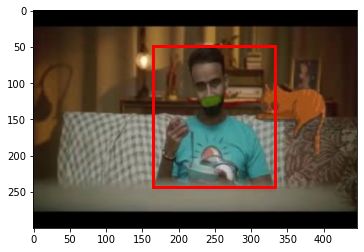

In [44]:
# before transformation

im = cv2.imread(str(df_train.values[100][8]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, df_train.values[100][9])

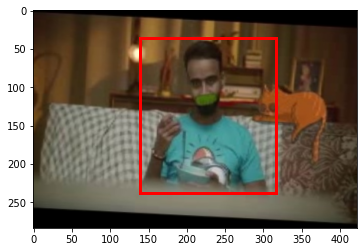

In [45]:
# after transformation

im, bb = transformsXY(str(df_train.values[100][8]),df_train.values[100][9],True )
show_corner_bb(im, bb)

# Split DataSet

In [46]:
df_train = df_train.reset_index()

X = df_train[['new_path', 'new_bb']]
y = df_train['class']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=34)

# Road Traffic Signs Dataset

In [48]:
class RoadDataset(Dataset):
    def __init__(self, paths, bb, y, transforms=False):
        self.transforms = transforms
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values
        
    def normalize(self, im):
        imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
        return (im - imagenet_stats[0])/imagenet_stats[1]
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        x, y_bb = transformsXY(path, self.bb[idx], self.transforms)
        x = self.normalize(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb

In [49]:
batch_size = 64

train_ds = RoadDataset(X_train['new_path'],X_train['new_bb'] ,y_train, transforms=True)
valid_ds = RoadDataset(X_test['new_path'],X_test['new_bb'],y_test)

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

# Bounding Box Model

In [56]:
class BB(nn.Module):
    def __init__(self):
        super(BB, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

# Training

In [57]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [58]:
def train_epocs(model, optimizer, train_dl, val_dl, epochs=10,C=1000):
    idx = 0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y_class, y_bb in train_dl:
            batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda()
            y_bb = y_bb.cuda().float()
            out_class, out_bb = model(x)
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
            loss_bb = loss_bb.sum()
            loss = loss_class + loss_bb/C
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            total += batch
            sum_loss += loss.item()
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, valid_dl, C)
        if (i+1) % 10 == 0:
            print("i:%4d train_loss:%5.3f val_loss:%5.3f val_acc:%5.3f" % ((i+1), train_loss, val_loss, val_acc))
    return sum_loss/total

In [59]:
def val_metrics(model, valid_dl, C=1000):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y_class, y_bb in valid_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        sum_loss += loss.item()
        total += batch
    return sum_loss/total, correct/total

In [60]:
model = BB().cuda()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.002)

In [61]:
train_epocs(model, optimizer, train_dl, valid_dl, epochs=101)

i:  10 train_loss:0.750 val_loss:185.317 val_acc:0.000
i:  20 train_loss:0.724 val_loss:8.364 val_acc:0.568
i:  30 train_loss:0.721 val_loss:0.748 val_acc:1.000
i:  40 train_loss:0.743 val_loss:1.409 val_acc:0.865
i:  50 train_loss:0.665 val_loss:10.126 val_acc:0.622
i:  60 train_loss:0.629 val_loss:0.646 val_acc:1.000
i:  70 train_loss:0.599 val_loss:3.779 val_acc:0.595
i:  80 train_loss:0.561 val_loss:2.194 val_acc:0.730
i:  90 train_loss:0.475 val_loss:0.865 val_acc:0.946
i: 100 train_loss:0.405 val_loss:0.427 val_acc:1.000


0.6890634048816769

# Prediction

In [62]:
# Predict the first image of the validation set
test_batch = next(iter(valid_dl))
test_batch[0] = test_batch[0].type(torch.cuda.FloatTensor).cuda()

In [63]:
out, bb = model(test_batch[0])

In [64]:
print('Class :', idx_to_class[torch.argmax(out[0]).item()])

Class : fight


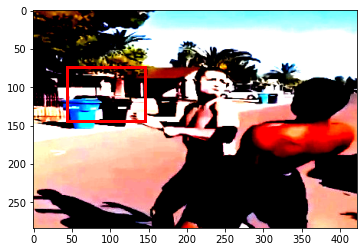

In [65]:
show_corner_bb(np.moveaxis(test_batch[0][0].cpu().numpy(), 0, 2), bb.detach().cpu().numpy().astype(int)[0])